In [1]:
import io
import numpy as np
import matplotlib
#     matplotlib.use('Agg')
from matplotlib import pyplot as plt
from PIL import Image


def make_scalebar(num_ticks_top,
                  step_ticks_top,
                  num_ticks_bottom,
                  step_ticks_bottom,
                  bottom_units_per_pixel,
                  scale_top=1.0,
                  scale_bottom=3.28084,
                  units_top='feet',
                  units_bottom='meters'):
    """Renders a dual scale bar as a PIL Image.

    Parameters
    ----------
    num_ticks_top, num_ticks_bottom : int
      number of ticks, including starting and ending points, to use for
      drawing scale bars
    step_ticks_top, step_ticks_bottom : int
      amount that each successive tick adds to previous tick
    bottom_units_per_pixel : numeric
      the width of each pixel in the resulting image in the same units as the
      bottom scale bar. This parameters helps resize the resulting figure
      to ensure an accurate scale is generated.
    scale_top, scale_bottom : numeric
      relative scales of units in top and bottom scale bars
    units_top, units_bottom : str
      string used to label units on the last tick in the scale bar

    Returns
    -------
    img : PIL Image
      the dual scale bar rendered as a in-memory image
    """
    DPI = 350
    DEFAULT_WIDTH = 1.5
    DEFAULT_HEIGHT = 0.15

    width_top = (num_ticks_top - 1) * step_ticks_top * (scale_top /
                                                        scale_bottom)
    width_bot = (num_ticks_bottom - 1) * step_ticks_bottom
    min_top, max_top = -width_top / 2, width_top / 2
    min_bot, max_bot = -width_bot / 2, width_bot / 2
    both_min, both_max = min(min_top, min_bot), max(max_top, max_bot)

    fig = plt.figure(frameon=False)
    fig.set_size_inches(DEFAULT_WIDTH, DEFAULT_HEIGHT)
    fig.dpi = DPI
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # make the top scalebar
    # first, the line
    ax.plot((min_top, max_top), (1.0, 1.0), lw=0.25, color='black')
    # then, create the tick marks
    ticks_top = np.linspace(min_top, max_top, num_ticks_top)
    for i, x in enumerate(ticks_top):
        ax.plot((x, x), (1.0, 3.0), lw=0.25, color='black')
        # add the labels for each tick mark
        ax.text(x,
                4.0,
                '{:,d}'.format(step_ticks_top * i),
                horizontalalignment='center',
                verticalalignment='bottom',
                fontname='arial',
                fontsize=2)
        # add the units after the last tick mark
        if x == ticks_top[-1]:
            spaces = ' ' * len('{:,d}'.format(step_ticks_top * i))
            ax.text(x,
                    4.0,
                    spaces + units_top,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    fontname='arial',
                    fontsize=2)

    # make the bottom scalebar
    # first, the line
    ax.plot((min_bot, max_bot), (-1, -1), lw=0.25, color='black')
    # then, create the tick marks
    ticks_bot = np.linspace(min_bot, max_bot, num_ticks_bottom)
    for i, x in enumerate(ticks_bot):
        ax.plot((x, x), (-1.0, -3.0), lw=0.25, color='black')
        # add the labels for each tick mark
        ax.text(x,
                -4.0,
                '{:,d}'.format(step_ticks_bottom * i),
                horizontalalignment='center',
                verticalalignment='top',
                fontname='arial',
                fontsize=2)
        # add the units after the last tick mark
        if x == ticks_bot[-1]:
            spaces = ' ' * len('{:,d}'.format(step_ticks_bottom * i))
            ax.text(x,
                    -4.0,
                    spaces + units_bottom,
                    horizontalalignment='left',
                    verticalalignment='top',
                    fontname='arial',
                    fontsize=2)

    # set display options so that ticks and labels are appropriately sized
    ax.set_ylim(-10, 10)
    ax.set_xlim(both_min * 1.05, both_max * 1.30)
    ax.axis('off')

    # calculate units per pixel for top scale bar
    img_coords_step_bot = fig.dpi_scale_trans.inverted().transform(
        ax.transData.transform(((ticks_bot[0], 1), (ticks_bot[-1], 1)))) * DPI

    img_scale_bot = (step_ticks_bottom *
                     (num_ticks_bottom - 1)) / (img_coords_step_bot[1][0] -
                                                img_coords_step_bot[0][0])
    # calculate adjustment factor to resize figure to enforce accurate scale
    adjust = img_scale_bot / bottom_units_per_pixel
    # update figure size with adjustment factor
    fig.set_size_inches(*(fig.get_size_inches() * adjust))
    # convert to PIL Image
    img = plt_to_pil_image(fig, dpi=DPI)

    return img


def plt_to_pil_image(figure, dpi=350):
    """Captures a user-provided figure as an in-memory image.

    Parameters
    ----------
    figure : matplotlib Figure
      the figure to be rendered as an image

    Returns
    -------
    img : PIL Image
      the figure, rendered as an image
    """
    # set user-provided figure as current figure
    fig = plt.figure(figure.number)
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=dpi)
    buf.seek(0)
    img = Image.open(buf)

    return img

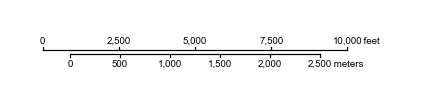

In [2]:
img = make_scalebar(num_ticks_top=5, step_ticks_top=2500,
                    num_ticks_bottom=6, step_ticks_bottom=500, bottom_units_per_pixel=10)

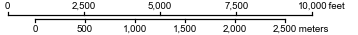

In [3]:
img

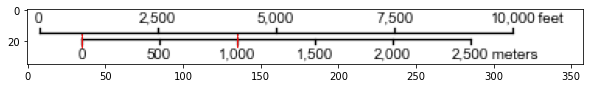

In [4]:
# check to confirm accurate scale
# given a `bottom_units_per_pixel` of 10,
# 100 pixels should span 1,000 units on the lower scale bar

fig, ax = plt.subplots(figsize=(10,1))
arr = np.array(img)
# draw red lines that are 100 pixels apart on top of the scalebar
arr[16:25,35:36,:] = (255, 0, 0, 255)
arr[16:25,135:136,:] = (255, 0, 0, 255)

ax.imshow(arr);